# Feature Engineering

I'm going to outline a strategy similar to the fast.ai machine learning course. The general plan is to 
1. Build a simple, decent random forset model
2. Use this to understand which features are most imporatnt, focus on improving and expanding upon these features
3. Step back with improved features and try a set of models to find the best for this application
4. Tune hyperparamaters

First, though, I need a validation dataset. Since the goal is to predict into the future, I'll use the chronological end of my dataset for validation. If we take everything starting in 2017 and after, that will be ~15% of the total data

In [61]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
sns.set()
%matplotlib inline

In [62]:
data = pd.read_csv('sar_weather_df.csv')

validate = data[data.Year > 2016]
train = data[data.Year <= 2016]

print(train.shape, validate.shape)

(5461, 46) (820, 46)


In [63]:
print(train.columns)

# remove the date and station codes, since they won't be useful for random forest training
train.drop(['date', 'DATE', 'STATION_x', 'NAME_x', 'STATION_y','NAME_y'], axis=1, inplace=True)
validate.drop(['date', 'DATE','STATION_x', 'NAME_x', 'STATION_y','NAME_y'], axis=1, inplace=True)

Index(['date', 'mission', 'Year', 'Month', 'Week', 'Day', 'Dayofweek',
       'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end',
       'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Elapsed',
       'STATION_x', 'NAME_x', 'DATE', 'AWND_x', 'FMTM', 'PGTM', 'PRCP_x',
       'TAVG_x', 'TMAX_x', 'TMIN_x', 'TSUN', 'WDF2', 'WDF5', 'WSF2', 'WSF5',
       'WT01', 'WT02', 'WT03', 'WT05', 'WT08', 'WT10', 'STATION_y', 'NAME_y',
       'AWND_y', 'PRCP_y', 'SNWD', 'TAVG_y', 'TMAX_y', 'TMIN_y', 'TOBS',
       'WESD'],
      dtype='object')


/anaconda3/envs/python3.7/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [64]:
y_train = train['mission']
X_train = train.drop('mission', axis=1)

y_validate = validate['mission']
X_validate = validate.drop('mission', axis=1)

In [95]:
m = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print(m.score(X_train, y_train))
print(m.score(X_validate, y_validate))
print(m.oob_score_)

1.0
0.6634146341463415
0.7093938839040469


Okay, so we have something to start with. The accuracy isn't grat, but we don't have that many features to work with. I'm curious what the probs that it predicts looks like.

                0           1
count  820.000000  820.000000
mean     0.621866    0.378134
std      0.103593    0.103593
min      0.270000    0.120000
25%      0.550000    0.300000
50%      0.630000    0.370000
75%      0.700000    0.450000
max      0.880000    0.730000


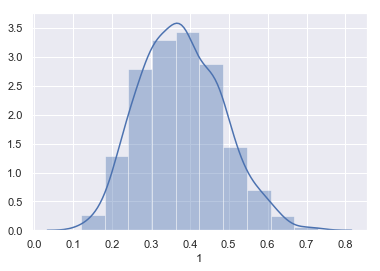

In [92]:
predictions = pd.DataFrame(m.predict_proba(X_validate))
sns.distplot(predictions[1], bins=10) #plot the prediction liklihood of a mission
print(predictions.describe())

Interesting. It's never more than 73% sure that a mission will happen. The negative predictive power is a bit better, getting as low as 12% liklihood. 

How can we improve our predictions? Add more features? Holidays?

In [101]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, X_train); fi[:10]

,cols,imp
15,PGTM,0.061781
12,Elapsed,0.060205
5,Dayofyear,0.053913
4,Dayofweek,0.053395
13,AWND_x,0.050678
3,Day,0.048017
18,TMAX_x,0.047546
35,TMAX_y,0.046835
19,TMIN_x,0.045517
22,WDF5,0.043574


In [102]:
# WHAT IS THE BASELINE MODEL?
# Always predict no?
# Random weighted coin flip?

# DO the shuffle analysis to test the impact of each factor in the model